# Image registration

Here we detect the 2 subimages from a larger image and perform image registration to align the patterns.

In [1]:
## Preamble (import ing the required libraries)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error

import diff_spotter as ds
from importlib import reload

# for plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})

# plt.style.use('seaborn')
plt.style.use('seaborn-whitegrid')
plt.rc('pdf',fonttype=42)

import seaborn as sns
sns.mpl.rc('figure', figsize = (14, 8))
sns.set_context(
    'notebook', font_scale=2.5, rc={'lines.linewidth': 2.5})

## 1. Registration from 2 images

This is the simplest case: we align the images (registration) from already selected images on a scanned image (HP simple scanner), so that they are flat.


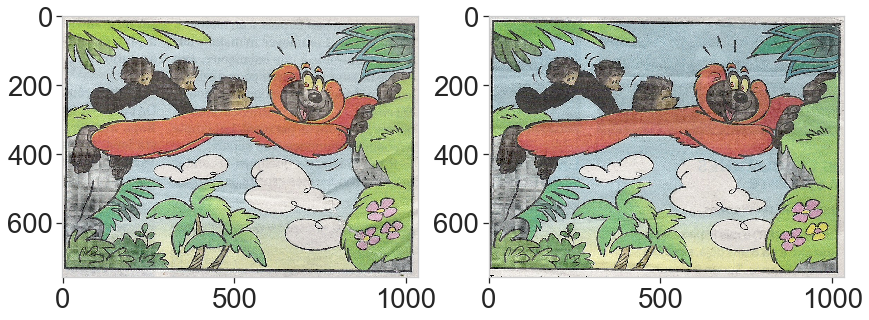

In [2]:
reload(ds)

# Read and display the 2 images

# 1, 2, 3, 6, or 8
image_name = 'data/diff1'

img_a = cv2.imread(image_name+'_a.png')
img_b = cv2.imread(image_name+'_b.png')

ds.display_2img(img_a, img_b)

We aligne the two images on top of each other.

In this first step, we start from two scanned images, so the transformation will be limited to a translation.

In [3]:
reload(ds)
img_a_aligned, img_b_aligned = ds.align_images(img_a, img_b)

# to avoid having black frame around diff images
img_a_aligned[img_b_aligned[:, :, :] == 0] = 0

In [4]:
# save the two aligned images

cv2.imwrite(image_name+'_a_aligned.png', img_a_aligned)
cv2.imwrite(image_name+'_b_aligned.png', img_b_aligned)

True

In [5]:
reload(ds)

# do it for all images
for n in ['1', '2', '3', '6', '8']:
    image_name = 'data/diff'+n
    
    ds.register_flat(image_name)

## 2. Detect the 2 images

We complicate the situation in this section: the 2 images are in a larger image. We need to detect them and extract them.

Ideas:
- template matching
- feature detection and matching
- lower resolution + matching
- sub area exctraction and matching (1/8)


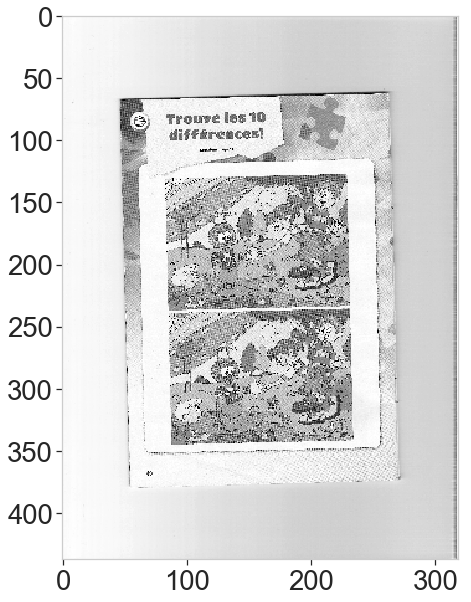

In [438]:
reload(ds)

image_name = 'data/diff8'
img = cv2.imread(image_name+'.png', cv2.IMREAD_GRAYSCALE)


#img = cv2.imread(image_name+'.png')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,1]

# create a blurred small version
# resampling factor
#rf = int(max(img.shape)/400)
rf = int(max(img.shape)/400)

#img_small = cv2.medianBlur(img[::rf, ::rf], 1)
img_small = img[::rf, ::rf]

ds.display_img(img_small)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[array([[ 151,  237,   84,   94, 7896],
       [ 147,  129,   85,   94, 7990]])]
[]
[array([[   89,   237,   147,   110, 16170],
       [   86,   129,   147,   110, 16170]])]
[array([[   88,   237,   148,   110, 16280],
       [   85,   129,   148,   110, 16280]]), array([[  105,     5,   181,   370, 66970],
       [  161,     0,   158,   438, 69204]])]
[array([[   85,   129,   148,   110, 16280],
       [   87,   237,   149,   110, 16390]])]
[array([[   85,   129,   148,   110, 16280],
       [   87,   237,   149,   110, 16390]])]
[array([[   87,   237,   152,   110, 16720],
       [   84,   129,   149,   110, 16390]])]
[]


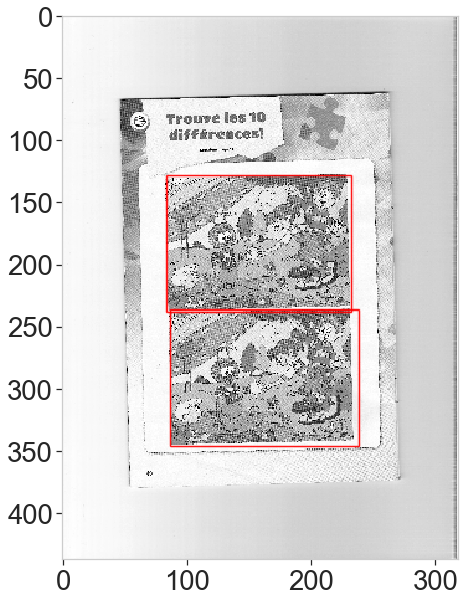

In [439]:
reload(ds)


result = ds.find_images(img_small)
    
ds.display_img(result)



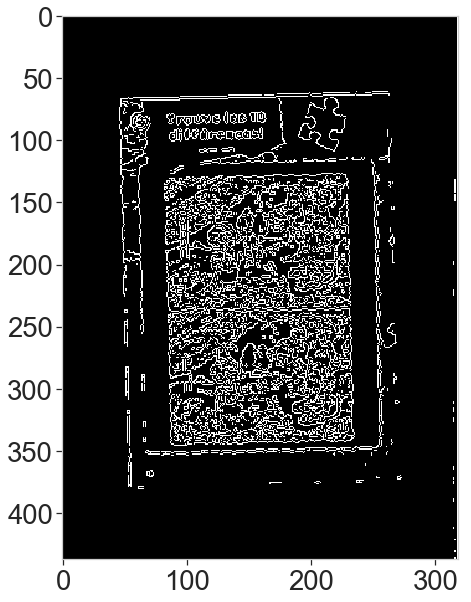

In [440]:

img_src = img_small

# Calculate the median pixel value
med_val = np.median(img_src)
# Lower bound is either 0 or 70% of the median value, whicever is higher
lower = int(max(0, 0.7* med_val))
# Upper bound is either 255 or 30% above the median value, whichever is lower
upper = int(min(255,1.3 * med_val))

edges = cv2.Canny(img_src, threshold1=lower , threshold2=upper)
#edges = cv2.Canny(image=img_small, threshold1=0, threshold2=120)

ds.display_img(edges)

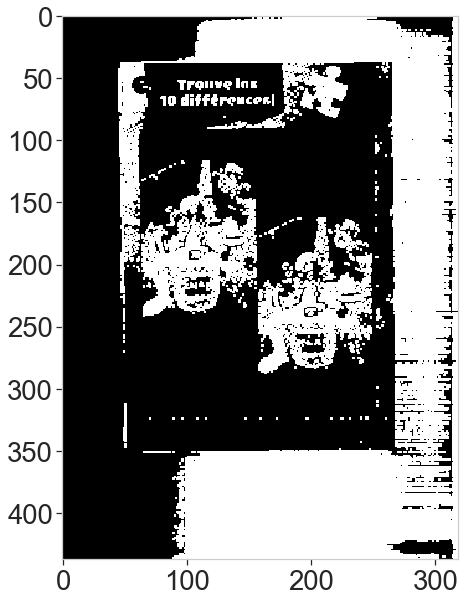

In [316]:
min_thres = 200
ret, binary = cv2.threshold(img_small, min_thres, 255, cv2.THRESH_BINARY_INV)

kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(2,2))
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

#dilate = cv2.morphologyEx(opened, cv2.MORPH_DILATE, kernel*2)

ds.display_img(opened)

In [317]:
#contours = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

image, contours, hierarchy = cv2.findContours(edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

bboxes = []
rboxes = []
cnts = []
dst = img_small.copy()

for cnt in contours:
    ## Get the stright bounding rect
    
    #print(cnt)
    
    #continue
    bbox = cv2.boundingRect(cnt)
    x,y,w,h = bbox
    
    if w<30 or h < 30 or w*h < 2000 or w > 500:
        continue

    ## Draw rect
    #cv2.rectangle(dst, (x,y), (x+w,y+h), (255,0,0), 1, 16)
    cv2.rectangle(dst, (x,y), (x+w,y+h), (255,0,0), 1, 16)


    ## Get the rotated rect
    #rbox = cv2.minAreaRect(cnt)
    #(cx,cy), (w,h), rot_angle = rbox
    #print("rot_angle:", rot_angle)  

    ## backup 
    #bboxes.append(bbox)
    #rboxes.append(rbox)
    #cnts.append(cnt)

1657


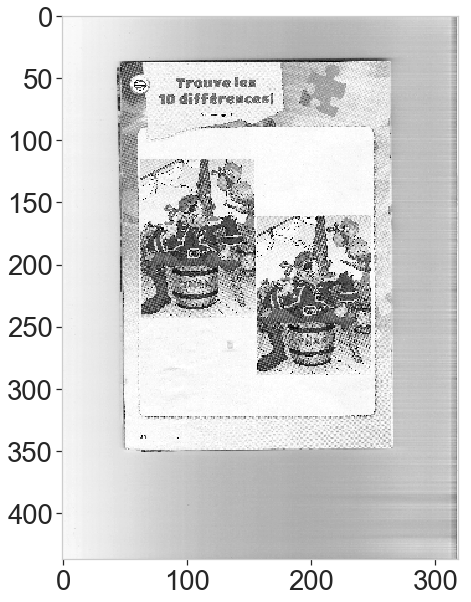

In [318]:
ds.display_img(dst)

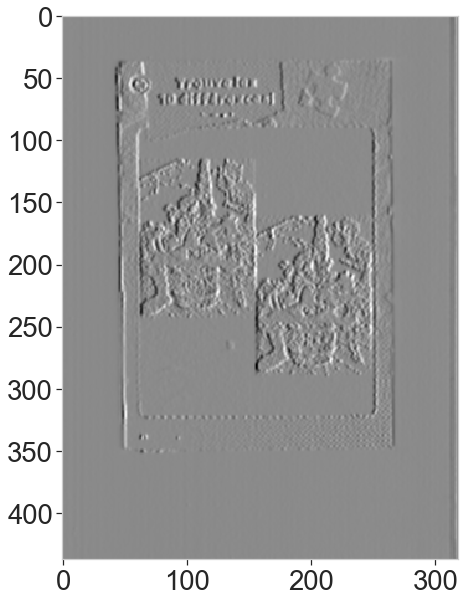

In [276]:

laplacian = cv2.Laplacian(img_small,cv2.CV_64F)

sobelx = cv2.Sobel(img_small,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img_small,cv2.CV_64F,0,1,ksize=5)


ds.display_img(sobelx)



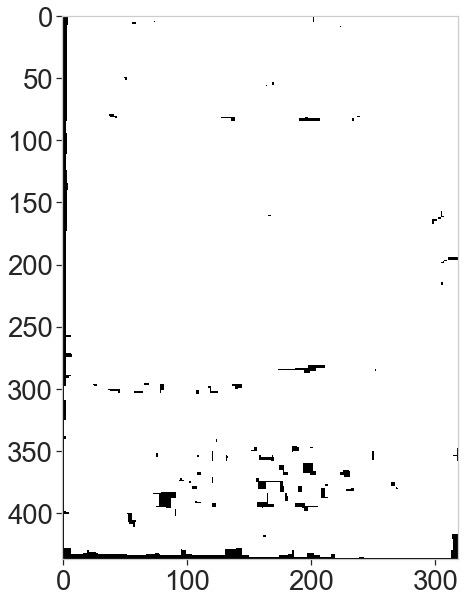

In [246]:
min_thres = 240
ret, binary = cv2.threshold(img_small, min_thres, 255, cv2.THRESH_BINARY_INV)

kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(5,5))
opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
dilate = cv2.morphologyEx(opened, cv2.MORPH_DILATE, kernel*2)


#res = np.hstack((h, normed, opened))
ds.display_img(dilate)

In [313]:
#contours = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

image, contours, hierarchy = cv2.findContours(opened, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

bboxes = []
rboxes = []
cnts = []
#dst = img_small.copy()

dst = cv2.cvtColor(img_small, cv2.COLOR_GRAY2BGR)

for cnt in contours:
    ## Get the stright bounding rect
    
    #print(cnt)
    
    #continue
    bbox = cv2.boundingRect(cnt)
    x,y,w,h = bbox
    
    if w<30 or h < 30 or w*h < 2000 or w > 500:
        continue

    ## Draw rect
    cv2.rectangle(dst, (x,y), (x+w,y+h), (0,0,255), 1, 16)

    ## Get the rotated rect
    #rbox = cv2.minAreaRect(cnt)
    #(cx,cy), (w,h), rot_angle = rbox
    #print("rot_angle:", rot_angle)  

    ## backup 
    #bboxes.append(bbox)
    #rboxes.append(rbox)
    #cnts.append(cnt)

711


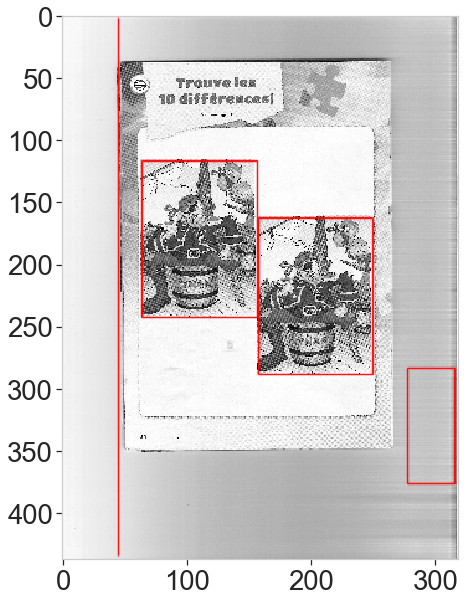

In [314]:
ds.display_img(dst)

In [319]:
hierarchy

array([[[   1,   -1,   -1,   -1],
        [   2,    0,   -1,   -1],
        [   3,    1,   -1,   -1],
        ...,
        [1655, 1653,   -1, 1563],
        [  -1, 1654,   -1, 1563],
        [  -1, 1563,   -1,   -1]]], dtype=int32)

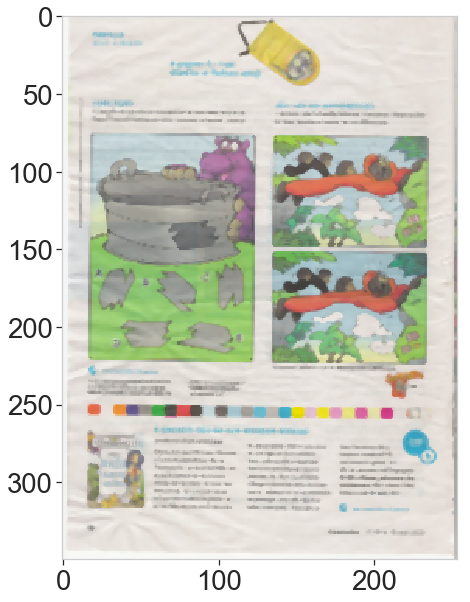

In [46]:
reload(ds)

image_name = 'data/diff1'
img = cv2.imread(image_name+'.png')

scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
resized = cv2.medianBlur(resized, 3)

ds.display_img(resized)

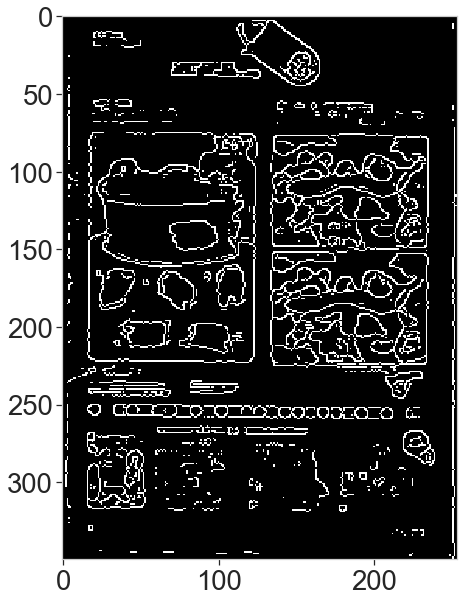

In [26]:
#kernel = np.ones((6,6), np.float64)/40

#b = cv2.filter2D(img, -1, kernel)

edges = cv2.Canny(resized, 100, 100)

ds.display_img(edges)

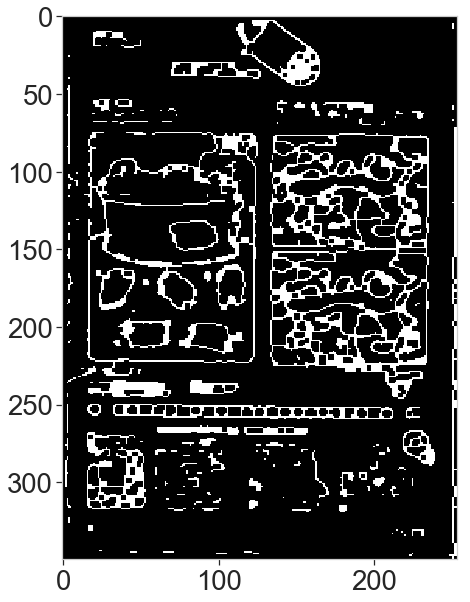

In [36]:
kernel2= cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel2)

ds.display_img(closed)


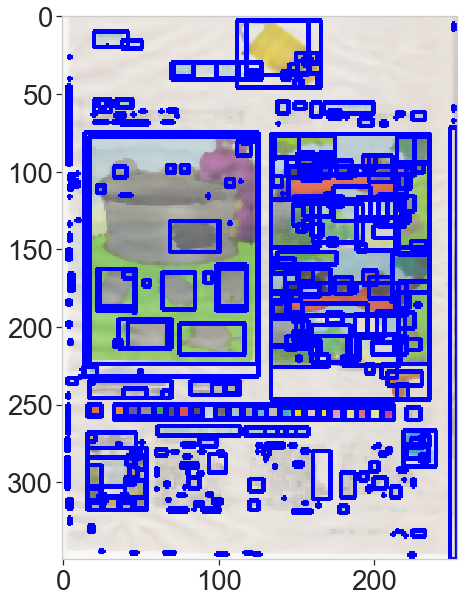

In [43]:
img_cont = resized.copy()

_,contours,h = cv2.findContours(closed,1,2) 

for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    cv2.rectangle(img_cont, (x,y), (x+w,y+h), (255,0,0), 2)

ds.display_img(img_cont)



In [ ]:
## reload(ds)

image_name = 'data/diff1'
img = cv2.imread(image_name+'.png')

scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
e
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
resized = cv2.medianBlur(resized, 5)

ds.display_img(resized)

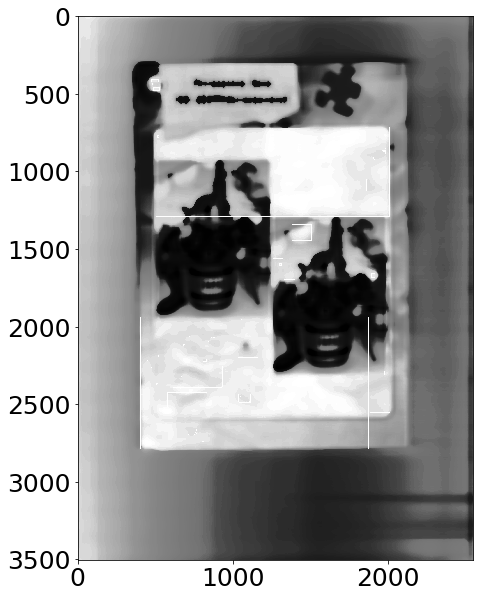

In [1117]:
img_cont = img.copy()

ret,binary = cv2.threshold(img,230,255,1)
 
_,contours,h = cv2.findContours(binary,1,2) 

for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    cv2.rectangle(img_cont, (x,y), (x+w,y+h), (255,0,0), 2)

display_img(img_cont)

